# Captcha or Sequence Classification (WIP)

In [2]:
from fastai.vision.all import *
import PIL
from torch.nn import CTCLoss
from scipy.special import logsumexp  # log(p1 + p2) = logsumexp([log_p1, log_p2])

In [3]:
path = untar_data('https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip')

In [4]:
imgs = get_image_files(path)

In [5]:
imgs

(#1040) [Path('/home/ubuntu/.fastai/data/captcha_images_v2/by5y3.png'),Path('/home/ubuntu/.fastai/data/captcha_images_v2/efb3f.png'),Path('/home/ubuntu/.fastai/data/captcha_images_v2/76y6f.png'),Path('/home/ubuntu/.fastai/data/captcha_images_v2/e2d66.png'),Path('/home/ubuntu/.fastai/data/captcha_images_v2/c6we6.png'),Path('/home/ubuntu/.fastai/data/captcha_images_v2/p2m6n.png'),Path('/home/ubuntu/.fastai/data/captcha_images_v2/d66cn.png'),Path('/home/ubuntu/.fastai/data/captcha_images_v2/2yggg.png'),Path('/home/ubuntu/.fastai/data/captcha_images_v2/cffp4.png'),Path('/home/ubuntu/.fastai/data/captcha_images_v2/5npdn.png')...]

In [6]:
img = plt.imread(imgs[0])

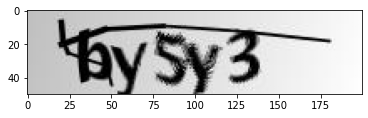

In [7]:
plt.imshow(img)

In [8]:
img.shape

(50, 200, 4)

In [9]:
path = imgs[0]

In [10]:
path

Path('/home/ubuntu/.fastai/data/captcha_images_v2/by5y3.png')

In [69]:
# Find all the unique labels
ld = set()
for f in imgs:
    for l in f.stem:
        ld.add(l)

label_mapper = "".join(sorted(ld))
l2i = { label_mapper[i]: i+1 for i in range(len(label_mapper)) } # labels to int + BLANK LABEL
i2l = { v: k for k, v in l2i.items() } # int to labels

In [70]:
l2i, i2l

({'2': 1,
  '3': 2,
  '4': 3,
  '5': 4,
  '6': 5,
  '7': 6,
  '8': 7,
  'b': 8,
  'c': 9,
  'd': 10,
  'e': 11,
  'f': 12,
  'g': 13,
  'm': 14,
  'n': 15,
  'p': 16,
  'w': 17,
  'x': 18,
  'y': 19},
 {1: '2',
  2: '3',
  3: '4',
  4: '5',
  5: '6',
  6: '7',
  7: '8',
  8: 'b',
  9: 'c',
  10: 'd',
  11: 'e',
  12: 'f',
  13: 'g',
  14: 'm',
  15: 'n',
  16: 'p',
  17: 'w',
  18: 'x',
  19: 'y'})

In [71]:
def label_func(path): return tensor([l2i[l] for l in path.stem])

In [72]:
def open_image(fname):
    img = PIL.Image.open(fname).convert('RGB')
    t = torch.Tensor(np.array(img))
    return t.permute(2,0,1).double()/255.0

In [73]:
class CaptchaImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        img,labels = self
        t = tensor(img)
        return show_image(t, title=''.join(str(i2l[i.item()]) for i in labels), ctx=ctx, **kwargs)

In [74]:
class CaptchaTransform(Transform):
    def __init__(self, files):
        self.files = files
        
    def encodes(self, i):
        file = self.files[i]
        label = label_func(file)
        img = open_image(file)
        return CaptchaImage(TensorImage(img), label)

In [75]:
bs = 128

In [76]:
splitter = RandomSplitter() 
train_idx , valid_idx = splitter(imgs) 
train_files = imgs[train_idx]
valid_files = imgs[valid_idx]
train_tl= TfmdLists(range(len(train_files)), CaptchaTransform(train_files))
valid_tl= TfmdLists(range(len(valid_files)), CaptchaTransform(valid_files))
dls = DataLoaders.from_dsets(train_tl, 
                             valid_tl, 
                             after_item=Resize((50,200), method=ResizeMethod.Squish),
                             after_batch=[Rotate(max_deg=6),
                                          Brightness(max_lighting=0.2, p=0.75, batch=False),
                                          Contrast(max_lighting=0.2, p=0.75, batch=False)], 
                             bs=bs)

In [77]:
@typedispatch
def show_batch(x:CaptchaImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): CaptchaImage(x[0][i],x[1][i]).show(ctx=ctx)

In [78]:
tensor(14).item()

14

In [79]:
one_batch = dls.one_batch()

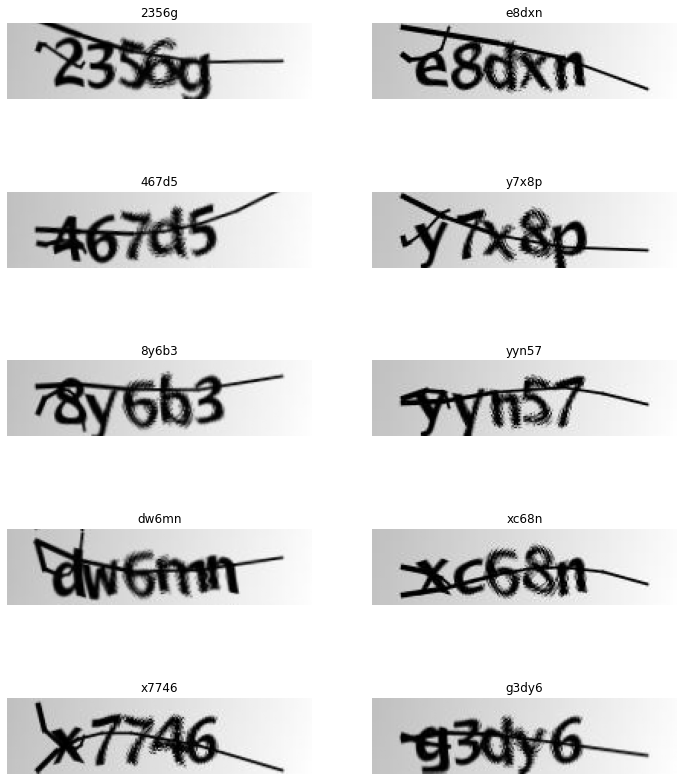

In [80]:
dls.show_batch(max_n=10)

In [23]:
n_chars = len(i2l)

In [24]:
n_chars * 5

95

## Simple Classification Model 

A simple image classification is used with output dimension is: `Number_of_vocab x Number_of_characters`

In [25]:
model = create_cnn_model(xresnet34, n_chars*5)

In [26]:
crit = LabelSmoothingCrossEntropyFlat()

In [25]:
def loss_captcha(output, target):
    output = output.view(-1, 5, n_chars)
    return crit(output, target)

In [26]:
def char_accu(inp, targ, axis=-1):
    inps = inp.reshape(-1, 5, n_chars)
    pred = inps.argmax(dim=-1)
    return (pred == targ).sum()/(pred.shape[0]*pred.shape[1])

In [27]:
def captcha_accu(inp, targ, axis=-1):
    inps = inp.reshape(-1, 5, n_chars)
    pred = inps.argmax(dim=-1)
    return ((pred == targ).all(axis=1)).sum()/targ.shape[0]

In [28]:
learn = Learner(dls, model, loss_captcha, metrics=[char_accu, captcha_accu])

In [29]:
learn.fit_one_cycle(40, 3e-3)

epoch,train_loss,valid_loss,char_accu,captcha_accu,time
0,4.476278,3.333658,0.065385,0.000000,00:30
1,4.417804,3.126414,0.071154,0.000000,00:29
2,4.304584,3.232960,0.058654,0.000000,00:29
3,4.187447,3.362142,0.062500,0.000000,00:30
4,4.027558,3.753680,0.091346,0.000000,00:30
5,3.866274,4.317540,0.092308,0.000000,00:30
6,3.705276,3.727203,0.130769,0.000000,00:30
7,3.543381,3.895546,0.121154,0.000000,00:30
8,3.367218,5.266652,0.099038,0.000000,00:30
9,3.192778,3.641559,0.182692,0.000000,00:30


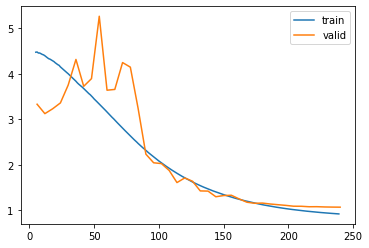

In [30]:
learn.recorder.plot_loss()

### No AvgPool

In the model used above, between the `body` and `head`, there is an `AvgPool2d` layer, which blurs all essential spatial information. So let's remove it and create our own `head`

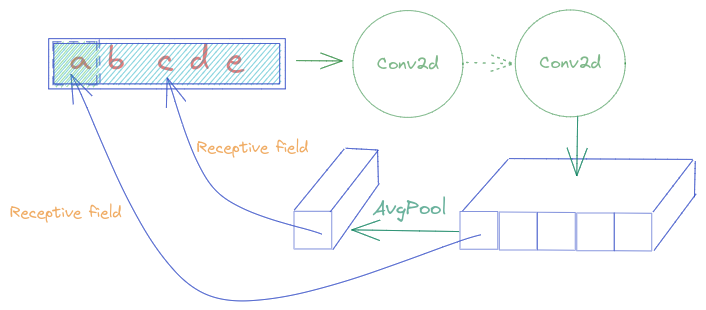

In [31]:
body = create_body(xresnet34)

In [37]:
head = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(7168,1000),
    nn.ReLU(),
    nn.BatchNorm1d(1000),
    nn.Dropout(0.5),
    nn.Linear(1000,95),
)

In [38]:
model = nn.Sequential(body, head)

In [39]:
learn = Learner(dls, model, loss_captcha, metrics=[char_accu, captcha_accu])

In [40]:
# learn.lr_find()

In [42]:
learn.fit_one_cycle(40, 3e-3)

epoch,train_loss,valid_loss,char_accu,captcha_accu,time
0,3.191548,2.941001,0.076923,0.000000,00:29
1,3.075782,2.899808,0.126923,0.000000,00:29
2,2.906533,2.830948,0.147115,0.000000,00:29
3,2.710024,2.763503,0.163462,0.000000,00:29
4,2.498606,2.544354,0.270192,0.000000,00:29
5,2.277901,2.081050,0.442308,0.000000,00:29
6,2.070913,1.772311,0.565385,0.076923,00:29
7,1.886266,1.783266,0.543269,0.067308,00:29
8,1.730296,1.627859,0.595192,0.072115,00:29
9,1.598513,1.726345,0.553846,0.052885,00:29


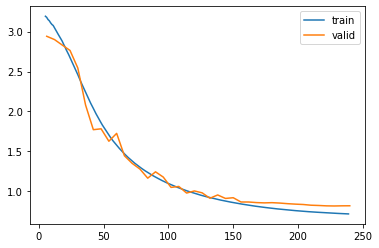

In [43]:
learn.recorder.plot_loss()

In [44]:
learn.unfreeze()

SuggestedLRs(valley=0.0002754228771664202)

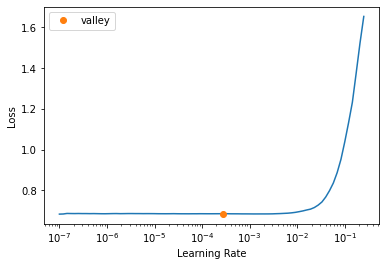

In [45]:
learn.lr_find()

In [47]:
learn.fit_one_cycle(4, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,char_accu,captcha_accu,time
0,0.684843,0.818710,0.951923,0.831731,00:30
1,0.683118,0.822131,0.948077,0.822115,00:30
2,0.684270,0.820947,0.950000,0.826923,00:30
3,0.684729,0.818542,0.950962,0.831731,00:29


As expected, the accuracy is much better in this version.

## CRNN (Coming soon)